# Exploratory and Descriptive Analysis (EDA) Parte II 

In [510]:
import pandas as pd
import seaborn as sns
import numpy as np
import joblib

from matplotlib import gridspec 
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor

# Funciones auxiliares

In [381]:
def metricas_validacion_cruzada(modelo, modelo_nombre,k, X, y ):
    MAE = cross_val_score(modelo, X, y, cv=k, scoring = 'neg_mean_absolute_error')
    r2 = cross_val_score(modelo, X, y, cv=k, scoring = 'r2')
    MSE = cross_val_score(modelo, X, y, cv=k, scoring = 'neg_mean_squared_error')
    RMSE = cross_val_score(modelo, X, y, cv=k, scoring = 'neg_root_mean_squared_error')


    return pd.DataFrame({'Modelo': modelo_nombre,
                    'MAE' : str(round(np.mean(-MAE),5))+'+/-'+str(round(np.std(-MAE),2)),
                  'MSE' : str(round(np.mean(-MSE),5))+'+/-'+str(round(np.std(-MSE),2)),
                  'RMSE' : str(round(np.mean(-RMSE),5))+'+/-'+str(round(np.std(-RMSE),2)),
                'R2' : str(round(np.mean(r2),5))+'+/-'+str(round(np.std(-r2),2))
    }, index = [0])

In [382]:
def metricas(modelo, yobs, yhat):
    # MAE 
    MAE = np.mean(np.abs(yobs-yhat))
    # MAPE
    MAPE = 100*np.mean(np.abs((yobs-yhat)/yobs))
    # RMSE
    RMSE = np.sqrt(np.mean((yobs-yhat)**2))
    # MSE
    MSE = np.mean((yobs-yhat)**2)
    # R2
    R2 = r2_score(yobs, yhat) 
    
    return pd.DataFrame({'Modelo' : modelo,
                         'MAE' : MAE,
                         'MAPE' : MAPE, 
                         'RMSE' : RMSE,
                         'MSE' : MSE, 
                         'R2': R2
    }, index =[0])

## Ejemplo

In [383]:
def validacion_cruzada(modelo,X,y, k_folds):
    metrica = pd.DataFrame()
    for i in range(k_folds):
        X_train_vc = X.drop(X[i*int(X.shape[0]/k_folds):(i+1)*int(X.shape[0]/k_folds)].index)
        y_train_vs = y.drop(y[i*int(y.shape[0]/k_folds):(i+1)*int(y.shape[0]/k_folds)].index)
        X_test_vc = X[i*int(X.shape[0]/k_folds):(i+1)*int(X.shape[0]/k_folds)]
        y_test_vs = y[i*int(y.shape[0]/k_folds):(i+1)*int(y.shape[0]/k_folds)]
        ajuste = LinearRegression().fit(X_train_vc,y_train_vs)
        y_ajustados = ajuste.predict(X_test_vc)
        metrica = metrica.append(metricas('Doblez '+ str(i), y_test_vs ,y_ajustados))
        
        salida = pd.DataFrame({'MAE': str(round(metrica['MAE'].mean(),2))+'+/-'+str(round(np.std(metrica['MAE']),2)),
                               'MAPE': str(round(metrica['MAPE'].mean(),2))+'+/-'+str(round(np.std(metrica['MAPE']),2)),
                               'RMSE': str(round(metrica['RMSE'].mean(),2))+'+/-'+str(round(np.std(metrica['RMSE']),2)),
                               'MSE':   str(round(metrica['MSE'].mean(),2))+'+/-'+str(round(np.std(metrica['MSE']),2)),
                               'R2':    str(round(metrica['R2'].mean(),2))+'+/-'+str(round(np.std(metrica['R2']),2))
                              }, index = [0])
    return salida

# Procesamiento de Datos

In [384]:
data = pd.read_csv('../data/kc_house_data.csv')

In [385]:
data['date'] = pd.to_datetime(data['date'], format ='%Y-%m-%d')
data['yr_built'] = pd.to_datetime(data['yr_built'], format = '%Y').dt.year
data.loc[data['yr_renovated']!= 0, 'yr_renovated' ] = pd.to_datetime(data.loc[data['yr_renovated']!= 0, 'yr_renovated' ], format = '%Y').dt.year

In [386]:
data.dtypes

id                        int64
date             datetime64[ns]
price                   float64
bedrooms                  int64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront                int64
view                      int64
condition                 int64
grade                     int64
sqft_above                int64
sqft_basement             int64
yr_built                  int64
yr_renovated              int64
zipcode                   int64
lat                     float64
long                    float64
sqft_living15             int64
sqft_lot15                int64
dtype: object

Limitemos nuestro análisis a propiedades de menos de un millón de dólares

In [387]:
data = data[data['price']<2000000]

data = data[(data['bedrooms']<6)&
     (data['sqft_living']<7000)&
     (data['sqft_above']<5000)&
     (data['sqft_basement']<3000)&
     (data['sqft_lot15']<20000)]

## Hay relación entre el precio y la fecha de la venta? 

In [6]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [7]:
data['month'] = data['date'].dt.month
data['week_of_year'] = data['date'].dt.weekofyear
data['day'] = data['date'].dt.day
data['day_of_week'] = data['date'].dt.dayofweek


C:\Users\Windows\AppData\Local\Temp/ipykernel_5588/3071502936.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data['week_of_year'] = data['date'].dt.weekofyear


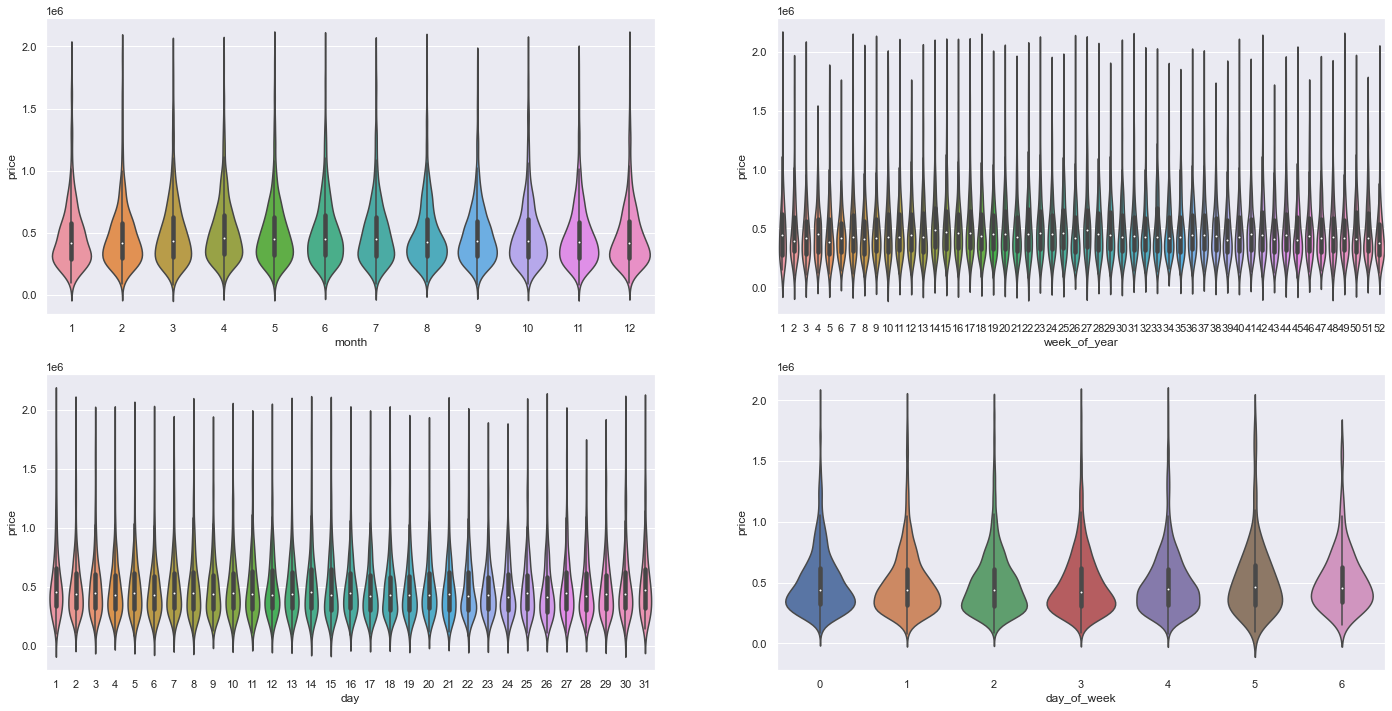

In [8]:
fig = plt.figure(figsize = (24,12))
gs = gridspec.GridSpec(2, 2, figure = fig)

ax1 = fig.add_subplot(gs[0,0])
ax1 = sns.violinplot(x = 'month', y='price', data = data)
ax2 = fig.add_subplot(gs[0,1])
ax2 = sns.violinplot(x = 'week_of_year', y='price', data = data)
ax3 = fig.add_subplot(gs[1,0])
ax3 = sns.violinplot(x = 'day', y='price', data = data)
ax4 = fig.add_subplot(gs[1,1])
ax4 = sns.violinplot(x = 'day_of_week', y='price', data = data)

## Relación del precio con Habitaciones y baños?

<AxesSubplot:xlabel='bedrooms', ylabel='price'>

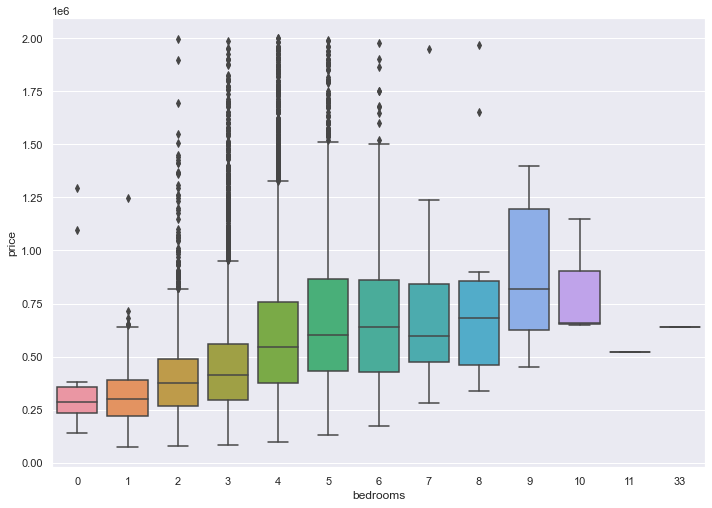

In [90]:
sns.boxplot(x='bedrooms', y='price', data = data)

<AxesSubplot:xlabel='bathrooms', ylabel='price'>

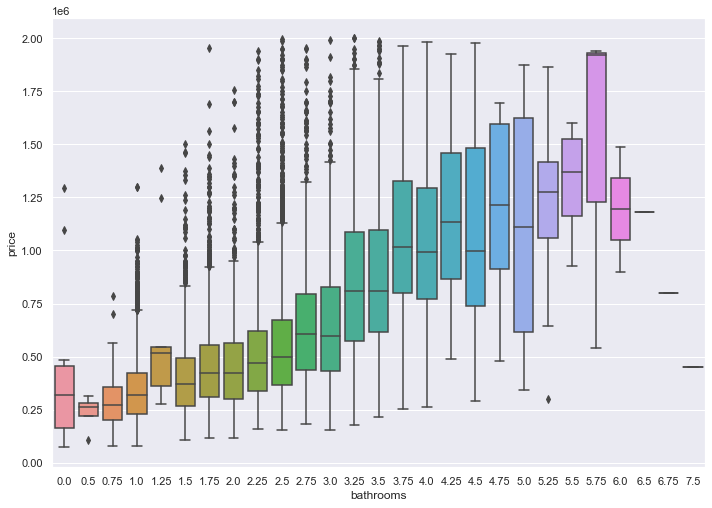

In [91]:
sns.boxplot(x='bathrooms', y='price', data = data)

## Relación entre diferentes categorías de área y precio

In [93]:
data.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'month', 'week_of_year',
       'day', 'day_of_week'],
      dtype='object')

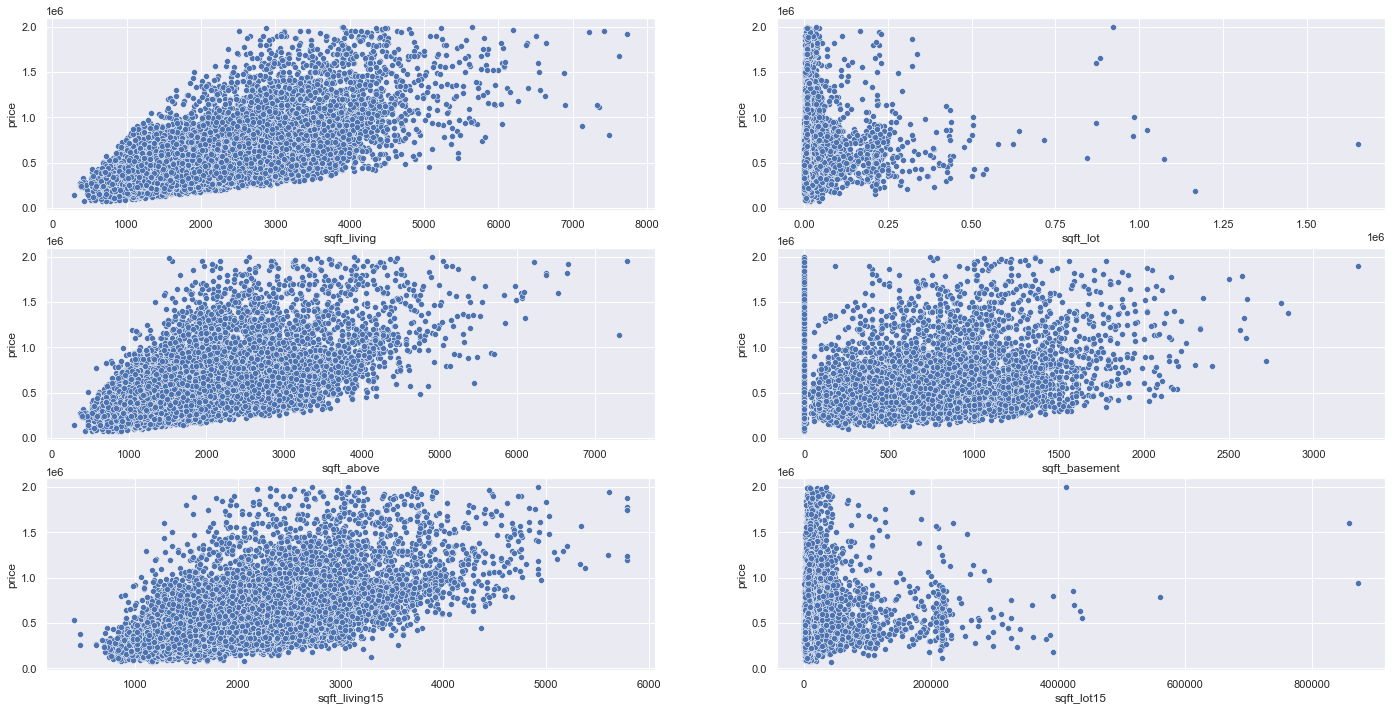

In [94]:
fig = plt.figure(figsize = (24,12))
gs = gridspec.GridSpec(3, 2, figure = fig)

ax1 = fig.add_subplot(gs[0,0])
ax1 = sns.scatterplot(x = 'sqft_living', y='price', data = data)
ax2 = fig.add_subplot(gs[0,1])
ax2 = sns.scatterplot(x = 'sqft_lot', y='price', data = data)
ax3 = fig.add_subplot(gs[1,0])
ax3 = sns.scatterplot(x = 'sqft_above', y='price', data = data)
ax4 = fig.add_subplot(gs[1,1])
ax4 = sns.scatterplot(x = 'sqft_basement', y='price', data = data)
ax5 = fig.add_subplot(gs[2,0])
ax5 = sns.scatterplot(x = 'sqft_living15', y='price', data = data)
ax6 = fig.add_subplot(gs[2,1])
ax6 = sns.scatterplot(x = 'sqft_lot15', y='price', data = data)

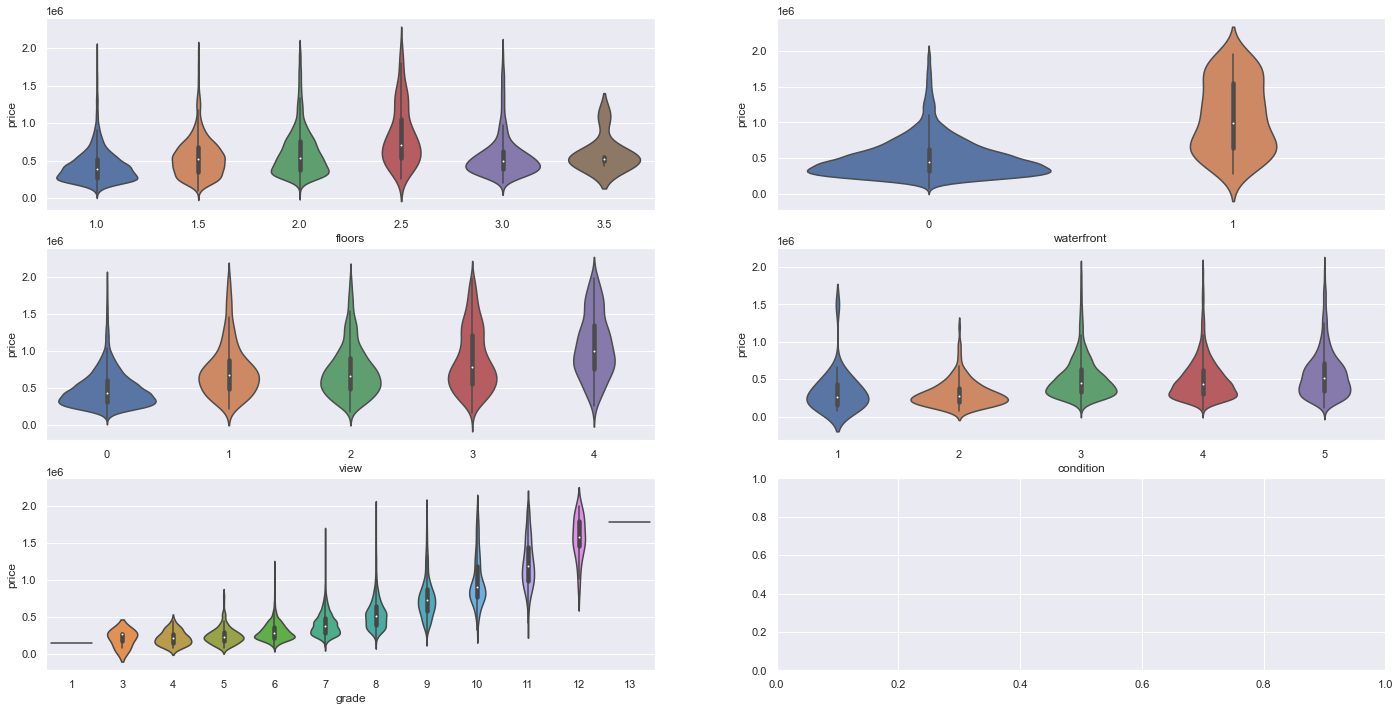

In [95]:
fig = plt.figure(figsize = (24,12))
gs = gridspec.GridSpec(3, 2, figure = fig)

ax1 = fig.add_subplot(gs[0,0])
ax1 = sns.violinplot(x = 'floors', y='price', data = data)
ax2 = fig.add_subplot(gs[0,1])
ax2 = sns.violinplot(x = 'waterfront', y='price', data = data)
ax3 = fig.add_subplot(gs[1,0])
ax3 = sns.violinplot(x = 'view', y='price', data = data)
ax4 = fig.add_subplot(gs[1,1])
ax4 = sns.violinplot(x = 'condition', y='price', data = data)
ax5 = fig.add_subplot(gs[2,0])
ax5 = sns.violinplot(x = 'grade', y='price', data = data)
ax6 = fig.add_subplot(gs[2,1])
# ax6 = sns.scatterplot(x = 'sqft_lot15', y='price', data = data)

# Preparación de la variables

In [388]:
data['yr_renovated_dummy'] = data['yr_renovated'].apply(lambda x: 1 if x!=0 else 0)

In [389]:
columns = ['price','bedrooms', 'bathrooms', 'sqft_living', 'floors','waterfront', 'view', 'condition', 'grade',
          'yr_built', 'yr_renovated_dummy']
data_aux = data[columns]

In [390]:
data_aux['property_age'] = 2015-data_aux['yr_built']

C:\Users\Windows\AppData\Local\Temp/ipykernel_5588/2804049904.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_aux['property_age'] = 2015-data_aux['yr_built']


In [391]:
data_aux.head()

price  bedrooms  bathrooms  sqft_living  floors  waterfront  view  \
0  221900.0         3       1.00         1180     1.0           0     0   
1  538000.0         3       2.25         2570     2.0           0     0   
2  180000.0         2       1.00          770     1.0           0     0   
3  604000.0         4       3.00         1960     1.0           0     0   
4  510000.0         3       2.00         1680     1.0           0     0   

   condition  grade  yr_built  yr_renovated_dummy  property_age  
0          3      7      1955                   0            60  
1          3      7      1951                   1            64  
2          3      6      1933                   0            82  
3          5      7      1965                   0            50  
4          3      8      1987                   0            28

La existencia de la variable $y$ es lo que permite que nos refiramos a este tipo de problemas como **Aprendizaje Supervisado**

In [392]:
# Matriz de información
X = data_aux.drop(columns = ['price'])
# Variable respuesta
y = data_aux['price']

## Validación de modelo (Train vs Test)

[Documentación Oficial de Scikit-Learn](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation)

Se genera la partición en conjunto de entrenamiento (80%) y conjunto de test (20%)

In [393]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [394]:
X_train.head()

bedrooms  bathrooms  sqft_living  floors  waterfront  view  condition  \
17118         4       3.50         3920     2.0           0     0          3   
15044         2       1.75         1660     1.0           0     0          3   
11264         3       1.75         2060     1.0           0     0          5   
15673         3       1.50         1180     1.0           0     0          4   
13362         3       2.50         2770     2.0           0     2          3   

       grade  yr_built  yr_renovated_dummy  property_age  
17118      9      2004                   0            11  
15044      7      1942                   0            73  
11264      7      1951                   0            64  
15673      7      1959                   0            56  
13362      9      1992                   0            23

### Transformando X_train

In [395]:
for item in X_train.columns.to_list():
    if item != 'sqft_living':
        scaler = MinMaxScaler()
    if item == 'sqft_living':
        scaler = RobustScaler()
    X_train[[item]] = scaler.fit_transform(X_train[[item]])
    joblib.dump(scaler, '../parameters/'+item+'.sav')

In [396]:
X_train = X_train.drop(columns = ['yr_built'])

In [397]:
X_train.head()

bedrooms  bathrooms  sqft_living  floors  waterfront  view  condition  \
17118       0.8   0.666667     2.019417     0.4         0.0   0.0       0.50   
15044       0.4   0.333333    -0.174757     0.0         0.0   0.0       0.50   
11264       0.6   0.333333     0.213592     0.0         0.0   0.0       1.00   
15673       0.6   0.285714    -0.640777     0.0         0.0   0.0       0.75   
13362       0.6   0.476190     0.902913     0.4         0.0   0.5       0.50   

       grade  yr_renovated_dummy  property_age  
17118    0.6                 0.0      0.095652  
15044    0.4                 0.0      0.634783  
11264    0.4                 0.0      0.556522  
15673    0.4                 0.0      0.486957  
13362    0.6                 0.0      0.200000

In [398]:
y_train = np.log1p( y_train )

In [399]:
y_train.head()

17118    13.697854
15044    13.089842
11264    13.122265
15673    12.873905
13362    13.527763
Name: price, dtype: float64

### Transformando X_test

In [400]:
X_test.head()

bedrooms  bathrooms  sqft_living  floors  waterfront  view  condition  \
4886          4        2.5         2800     2.0           0     0          3   
7089          3        1.0         1270     1.0           0     0          3   
11444         5        1.0         1120     1.5           0     0          4   
8364          3        1.0         1050     1.0           0     0          3   
3614          4        2.5         3140     2.0           0     0          3   

       grade  yr_built  yr_renovated_dummy  property_age  
4886       8      1993                   0            22  
7089       7      1953                   0            62  
11444      7      1962                   0            53  
8364       7      1941                   0            74  
3614       9      1993                   0            22

In [401]:
for item in X_test.columns.to_list(): 
    scaler = joblib.load('../parameters/'+item+'.sav')
    X_test[[item]] = scaler.transform(X_test[[item]])

In [402]:
X_test = X_test.drop(columns= ['yr_built'])

In [403]:
X_test.head()

bedrooms  bathrooms  sqft_living  floors  waterfront  view  condition  \
4886        0.8   0.476190     0.932039     0.4         0.0   0.0       0.50   
7089        0.6   0.190476    -0.553398     0.0         0.0   0.0       0.50   
11444       1.0   0.190476    -0.699029     0.2         0.0   0.0       0.75   
8364        0.6   0.190476    -0.766990     0.0         0.0   0.0       0.50   
3614        0.8   0.476190     1.262136     0.4         0.0   0.0       0.50   

       grade  yr_renovated_dummy  property_age  
4886     0.5                 0.0      0.191304  
7089     0.4                 0.0      0.539130  
11444    0.4                 0.0      0.460870  
8364     0.4                 0.0      0.643478  
3614     0.6                 0.0      0.191304

# Machine Learning

Métricas usuales para evaluar modelos de Machine learning disponibles [aquí](https://scikit-learn.org/stable/modules/model_evaluation.html)

## Regresión Lineal

In [404]:
ajuste = LinearRegression().fit(X_train,y_train)

In [405]:
X_test.head()

bedrooms  bathrooms  sqft_living  floors  waterfront  view  condition  \
4886        0.8   0.476190     0.932039     0.4         0.0   0.0       0.50   
7089        0.6   0.190476    -0.553398     0.0         0.0   0.0       0.50   
11444       1.0   0.190476    -0.699029     0.2         0.0   0.0       0.75   
8364        0.6   0.190476    -0.766990     0.0         0.0   0.0       0.50   
3614        0.8   0.476190     1.262136     0.4         0.0   0.0       0.50   

       grade  yr_renovated_dummy  property_age  
4886     0.5                 0.0      0.191304  
7089     0.4                 0.0      0.539130  
11444    0.4                 0.0      0.460870  
8364     0.4                 0.0      0.643478  
3614     0.6                 0.0      0.191304

In [406]:
y_ajustado = ajuste.predict(X_test)

<AxesSubplot:xlabel='Actual', ylabel='Predicho'>

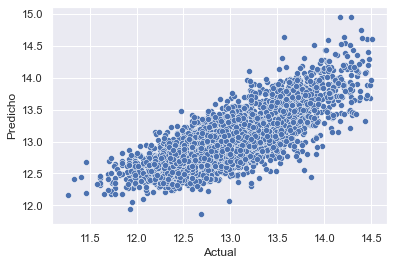

In [407]:
df = pd.DataFrame({'Actual': np.log1p( y_test ), 'Predicho': y_ajustado})
sns.scatterplot(x = 'Actual', y = 'Predicho', data = df)

### Validación test-train

In [106]:
metricas('regresión', np.log1p( y_test ),y_ajustado)

Modelo      MAE      MAPE      RMSE       MSE         R2
0  regresión  2.52453  19.31864  2.566645  6.587664 -26.092894

In [107]:
metricas('regresión',y_test,np.expm1(y_ajustado))

Modelo            MAE       MAPE           RMSE           MSE        R2
0  regresión  464555.515496  91.109266  539575.570835  2.911418e+11 -2.831408

### Validación cruzada

In [241]:
validacion_cruzada('Regresión', X,y, 10)

MAE          MAPE                 RMSE  \
0  121199.36+/-2381.99  27.68+/-1.93  167917.47+/-5986.09   

                              MSE           R2  
0  28232109291.42+/-2015356410.57  0.62+/-0.01

In [433]:
for item in X.columns.to_list():
    if item != 'sqft_living':
        scaler = MinMaxScaler()
    if item == 'sqft_living':
        scaler = RobustScaler()
    X[[item]] = scaler.fit_transform(X[[item]])

In [436]:
y = np.log1p(y)

In [294]:
metricas_validacion_cruzada(LinearRegression(), 'Regresión Lineal', 10, X,y)

Modelo          MAE         MSE         RMSE          R2
0  Regresión Lineal  0.25+/-0.01  0.1+/-0.01  0.31+/-0.01  0.6+/-0.01

In [ ]:
metricas_validacion_cruzada(LinearRegression(), 'Regresión Lineal', 10, X,y)

## Regresión Ridge

Para leer más acerca de la regresión [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) y acerca de Parameter Fine Tuning, vea [acá](https://medium.com/fintechexplained/how-to-fine-tune-your-machine-learning-models-to-improve-forecasting-accuracy-e18e67e58898) o [acá](https://machinelearningmastery.com/what-is-bayesian-optimization/)

In [442]:
params = {'alpha' : [1e-15,1e-10,1e-5,1e-3,0.1, 0.3, 0.5, 0.8,1,5,10,20,30]}
ridge = Ridge()
ridge_regression = GridSearchCV(ridge, params,scoring ='neg_mean_squared_error' , cv = 5)
ridge_regression.fit(X,y)

C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.38974e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.1104e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.08943e-17): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [1e-15, 1e-10, 1e-05, 0.001, 0.1, 0.3, 0.5,
                                   0.8, 1, 5, 10, 20, 30]},
             scoring='neg_mean_squared_error')

In [443]:
print(ridge_regression.best_params_)
print(ridge_regression.best_score_)

{'alpha': 0.1}
-0.09770277460038805


In [446]:
modelo_ridge = Ridge(alpha=0.1).fit(X_train, y_train)

In [447]:
X_test.head()

bedrooms  bathrooms  sqft_living  floors  waterfront  view  condition  \
4886        0.8   0.476190     0.932039     0.4         0.0   0.0       0.50   
7089        0.6   0.190476    -0.553398     0.0         0.0   0.0       0.50   
11444       1.0   0.190476    -0.699029     0.2         0.0   0.0       0.75   
8364        0.6   0.190476    -0.766990     0.0         0.0   0.0       0.50   
3614        0.8   0.476190     1.262136     0.4         0.0   0.0       0.50   

       grade  yr_renovated_dummy  property_age  
4886     0.5                 0.0      0.191304  
7089     0.4                 0.0      0.539130  
11444    0.4                 0.0      0.460870  
8364     0.4                 0.0      0.643478  
3614     0.6                 0.0      0.191304

In [448]:
y_ajustado = modelo_ridge.predict(X_test)

<AxesSubplot:xlabel='Actual', ylabel='Predicho'>

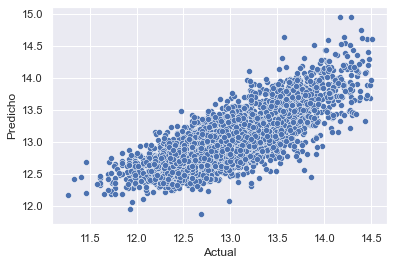

In [449]:
df = pd.DataFrame({'Actual': np.log1p(y_test), 'Predicho': y_ajustado})
sns.scatterplot(x = 'Actual', y = 'Predicho', data = df)

In [450]:
metricas('regresión', np.log1p( y_test ),y_ajustado)

Modelo       MAE      MAPE     RMSE       MSE        R2
0  regresión  0.250954  1.938223  0.31426  0.098759  0.593835

## Regresión Lasso


Para saber más de la regresión [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html).

In [470]:
params = {'alpha' : [1e-15,1e-10,1e-5,1e-3,0.1, 0.3, 0.5, 0.8,1,5,10,20,30]}
lasso = Lasso()
lasso_regression = GridSearchCV(lasso, params,scoring ='neg_mean_squared_error' , cv = 5)
lasso_regression.fit(X,y)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [1e-15, 1e-10, 1e-05, 0.001, 0.1, 0.3, 0.5,
                                   0.8, 1, 5, 10, 20, 30]},
             scoring='neg_mean_squared_error')

In [473]:
print(lasso_regression.best_params_)
print(lasso_regression.best_score_)

{'alpha': 1e-05}
-0.09770239130533503


In [474]:
modelo_lasso = Lasso(alpha = 1e-05).fit(X_train, y_train)
y_ajustado = modelo_lasso.predict(X_test)

<AxesSubplot:xlabel='Actual', ylabel='Predicho'>

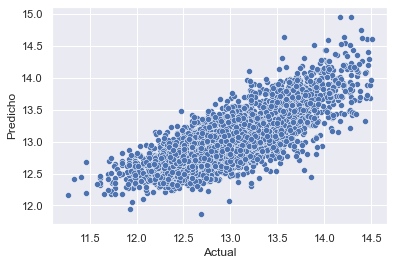

In [475]:
df = pd.DataFrame({'Actual': np.log1p(y_test), 'Predicho': y_ajustado})
sns.scatterplot(x = 'Actual', y = 'Predicho', data = df)

In [476]:
metricas('regresión Lasso', np.log1p( y_test ),y_ajustado)

Modelo       MAE      MAPE      RMSE       MSE        R2
0  regresión Lasso  0.250952  1.938211  0.314256  0.098757  0.593846

## Regresión Elástica (Regularizada = L1 (Lasso) + L2 (Ridge)) 

Para saber más de la regresión [elástica](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) (regularizada)

In [500]:
params = {
    'alpha':[1e-15,1e-10,1e-5,1e-3,0.1, 0.3, 0.5, 0.8,1,5,10,20,30],
    'l1_ratio':[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}
elastic = ElasticNet()
elastic_net = GridSearchCV(elastic, params,scoring ='neg_mean_squared_error' , cv = 5)
elastic_net.fit(X,y)

C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.376e+02, tolerance: 3.730e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.386e+02, tolerance: 3.746e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of 

C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.820e+02, tolerance: 3.730e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.838e+02, tolerance: 3.746e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider

C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.785e+01, tolerance: 3.795e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.336e+00, tolerance: 3.730e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider

C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.734e+02, tolerance: 3.746e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.954e+01, tolerance: 3.753e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider

C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.204e+01, tolerance: 3.795e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.490e+01, tolerance: 3.730e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider

C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.014e+00, tolerance: 3.746e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.765e+01, tolerance: 3.753e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider

C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.125e+03, tolerance: 3.730e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.129e+03, tolerance: 3.746e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of 

C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.506e+03, tolerance: 3.730e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.513e+03, tolerance: 3.746e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of 

C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.817e+03, tolerance: 3.730e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
C:\Users\Windows\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.825e+03, tolerance: 3.746e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of 

GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': [1e-15, 1e-10, 1e-05, 0.001, 0.1, 0.3, 0.5,
                                   0.8, 1, 5, 10, 20, 30],
                         'l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                      0.9, 1]},
             scoring='neg_mean_squared_error')

In [502]:
print(elastic_net.best_params_)

{'alpha': 1e-05, 'l1_ratio': 1}


In [503]:
modelo_elastico = ElasticNet(alpha = 1e-05, l1_ratio = 1).fit(X_train,y_train)
y_ajustado = modelo_elastico.predict(X_test)

<AxesSubplot:xlabel='Actual', ylabel='Predicho'>

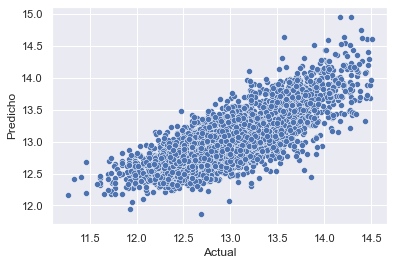

In [504]:
df = pd.DataFrame({'Actual': np.log1p(y_test), 'Predicho': y_ajustado})
sns.scatterplot(x = 'Actual', y = 'Predicho', data = df)

In [505]:
metricas('regresión elástica', np.log1p( y_test ),y_ajustado)

Modelo       MAE      MAPE      RMSE       MSE        R2
0  regresión elástica  0.250952  1.938211  0.314256  0.098757  0.593846

## K vecinos más cercanos (Regresión)

Para saber más sobre la versión Regresión del algoritmo de los $k$ vecinos más cercanos, entre [acá](https://scikit-learn.org/stable/modules/neighbors.html#regression)

In [514]:
params ={'n_neighbors':[3,5,7,10],
        'weights':['uniform', 'distance'],
        'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']}
kvecinos = KNeighborsRegressor()
modelo_kvecinos = GridSearchCV(kvecinos, params,scoring ='neg_mean_squared_error' , cv = 5)
modelo_kvecinos.fit(X,y)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [3, 5, 7, 10],
                         'weights': ['uniform', 'distance']},
             scoring='neg_mean_squared_error')

In [515]:
modelo_kvecinos.best_params_

{'algorithm': 'auto', 'n_neighbors': 10, 'weights': 'uniform'}

In [517]:
modelo_vecinos = KNeighborsRegressor(algorithm= 'auto', n_neighbors= 10, weights= 'uniform').fit(X_train,y_train)
y_ajustado = modelo_vecinos.predict(X_test)

<AxesSubplot:xlabel='Actual', ylabel='Predicho'>

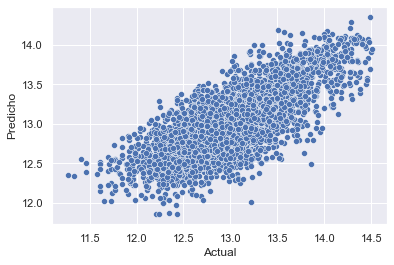

In [518]:
df = pd.DataFrame({'Actual': np.log1p(y_test), 'Predicho': y_ajustado})
sns.scatterplot(x = 'Actual', y = 'Predicho', data = df)

In [519]:
metricas('Vecinos más cercanos', np.log1p( y_test ),y_ajustado)

Modelo       MAE      MAPE      RMSE       MSE        R2
0  Vecinos más cercanos  0.258852  1.998441  0.325569  0.105995  0.564075

# Comparación de modelos

In [520]:
mod1 = metricas_validacion_cruzada(LinearRegression(), 'Regresión Lineal', 10, X,y)
mod2 = metricas_validacion_cruzada(Ridge(alpha=0.3), 'Regresión Ridge (0.3)', 10, X,y)
mod3 = metricas_validacion_cruzada(Ridge(alpha=0.1), 'Regresión Ridge (0.1)', 10, X,y)
mod4 = metricas_validacion_cruzada(Lasso(alpha=0.1), 'Regresión Lasso (0.1)', 10, X,y)
mod5 = metricas_validacion_cruzada(Lasso(alpha=1e-05), 'Regresión Lasso (1e-05)', 10, X,y)
mod6 = metricas_validacion_cruzada(ElasticNet(alpha = 1e-05, l1_ratio = 1), 'Regresión Elástica (1e-05,1)', 10, X,y)
mod7 = metricas_validacion_cruzada(KNeighborsRegressor(algorithm= 'auto', n_neighbors= 10, weights= 'uniform'), 'K vecinos más cercanos (10)', 10, X,y)

In [522]:
pd.concat([mod1,mod2,mod3, mod4, mod5, mod6, mod7])

Modelo             MAE             MSE  \
0              Regresión Lineal  0.25016+/-0.01  0.09774+/-0.01   
0         Regresión Ridge (0.3)  0.25013+/-0.01  0.09769+/-0.01   
0         Regresión Ridge (0.1)  0.25011+/-0.01  0.09769+/-0.01   
0         Regresión Lasso (0.1)  0.32488+/-0.02  0.15833+/-0.02   
0       Regresión Lasso (1e-05)  0.25012+/-0.01  0.09769+/-0.01   
0  Regresión Elástica (1e-05,1)  0.25012+/-0.01  0.09769+/-0.01   
0   K vecinos más cercanos (10)  0.25469+/-0.01  0.10378+/-0.01   

             RMSE              R2  
0  0.31239+/-0.01  0.59502+/-0.01  
0  0.31231+/-0.01  0.59526+/-0.01  
0  0.31231+/-0.01  0.59526+/-0.01  
0  0.39725+/-0.02  0.34593+/-0.03  
0  0.31231+/-0.01  0.59525+/-0.01  
0  0.31231+/-0.01  0.59525+/-0.01  
0  0.32156+/-0.02  0.57125+/-0.03